In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

users_similarity = pd.read_csv("users_similarity.csv", header=None)
movie_ratings = pd.read_csv("users.csv", header=None)

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


In [2]:
#Create training, validation, and test sets

np.random.seed(1234)
train_set = np.random.choice(users_similarity.shape[0], int(0.8*users_similarity.shape[0]), replace=False)
test_set = np.setdiff1d(range(users_similarity.shape[0]),train_set)

train_only_set = np.random.choice(train_set.shape[0], int(0.8*train_set.shape[0]), replace=False)
val_set = np.setdiff1d(range(train_set.shape[0]),train_only_set)

whole_train = users_similarity.loc[train_set][train_set]
train = users_similarity.loc[train_only_set][train_only_set]
val = users_similarity.loc[train_only_set][val_set]
test = users_similarity.loc[train_set][test_set]

In [3]:
#Main function where k-nearest-neighbors is used to find the k most similar neighbors, 
#calculate the average rating among those neighbors for each movie.
#Then, the RMSE is calculated.

def test_model(num, test_array, test_indexes):    
    num = num

    total_array = np.zeros((len(test_array.columns),num))
    idx = 0
    for i in test_array:
        number = 0
        array_num = np.zeros((len(test_array[i])))
        for j in test_array[i]:
            array_num[number] = j
            number += 1
        sim_users = array_num.argsort()[-num:]
        total_array[idx,:] = sim_users
        idx += 1


    predicted_ratings = np.zeros((total_array.shape[0],len(movie_ratings.columns)))
    for idx,i in enumerate(total_array):
        sum_ratings = movie_ratings.loc[total_array[idx,0],:]
        for x in range(1,num):
            sum_ratings += movie_ratings.loc[total_array[idx,x],:]

        avg = sum_ratings / num
        predicted_ratings[idx,:] = round(avg*2)/2

    actual_ratings = movie_ratings.loc[test_indexes,:]


    total = 0
    incorrect = 0
    sum_xi = 0
    for i in range(predicted_ratings.shape[0]):
        for j in range(predicted_ratings.shape[1]):
            if actual_ratings.iloc[i,j] != 0.0:
                sum_xi += (actual_ratings.iloc[i,j]-predicted_ratings[i,j])**2
                total += 1
                if predicted_ratings[i,j] != actual_ratings.iloc[i,j]:
                    incorrect += 1
    error_rate = incorrect/total
#     print(error_rate)

    rmse = np.sqrt(sum_xi/total)
    print('RMSE: ', rmse)
    return rmse,actual_ratings,predicted_ratings

In [4]:
#Iterate through the k-nearest neighbors algorithm for each value of k.

knn_array = np.array((1,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,100,125,150,175,200,225,250,275,300))
rmse_array = np.zeros((knn_array.shape[0]))

for idx,knn in enumerate(knn_array):
    print('Number of Neighbors: ', knn)
    rmse_array[idx],actual_ratings,predicted_ratings = test_model(knn, val, val_set)

Number of Neighbors:  1
RMSE:  1.8860753386127693
Number of Neighbors:  5
RMSE:  1.3656353566029271
Number of Neighbors:  10
RMSE:  1.2716401068026804
Number of Neighbors:  15
RMSE:  1.2355158339202539
Number of Neighbors:  20
RMSE:  1.2150190554383173
Number of Neighbors:  25
RMSE:  1.2015709200193563
Number of Neighbors:  30
RMSE:  1.1904720573630032
Number of Neighbors:  35
RMSE:  1.1839042023728854
Number of Neighbors:  40
RMSE:  1.1779448633917893
Number of Neighbors:  45
RMSE:  1.1724851699071859
Number of Neighbors:  50
RMSE:  1.1685234202827204
Number of Neighbors:  55
RMSE:  1.1651077942164259
Number of Neighbors:  60
RMSE:  1.1624174952254347
Number of Neighbors:  65
RMSE:  1.1611999923075766
Number of Neighbors:  70
RMSE:  1.1593059333942315
Number of Neighbors:  75
RMSE:  1.1577388293180966
Number of Neighbors:  100
RMSE:  1.1491164537268046
Number of Neighbors:  125
RMSE:  1.1441897041046076
Number of Neighbors:  150
RMSE:  1.1374264127246034
Number of Neighbors:  175
RMSE

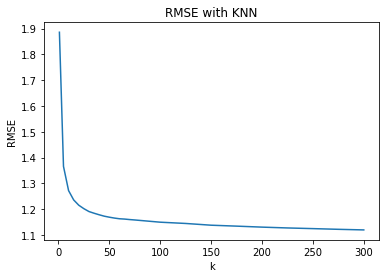

In [5]:
#Plot how RMSE changes as k increases

plt.plot(knn_array, rmse_array)
plt.title('RMSE with KNN')
plt.xlabel('k')
plt.ylabel('RMSE')
plt.show()

In [6]:
#Find the optimal value for k

for idx in range(1,knn_array.shape[0]):
    if (rmse_array[idx-1] - rmse_array[idx]) < 0.01:
        optimal_knn = knn_array[idx-1]
        break
print('Optimal Number of Neighbors: ', optimal_knn)


#Build the final model using the optimal k value and calculate the test set RMSE

rmse,actual_ratings,predicted_ratings = test_model(optimal_knn, test, test_set)

Optimal Number of Neighbors:  30
RMSE:  1.1622413959681743


In [7]:
#Find the top 25 recommended movies for each user

predicted_ratings = pd.DataFrame(data=predicted_ratings)
predicted_ratings = predicted_ratings.T

actual_ratings = pd.DataFrame(data=actual_ratings)
actual_ratings = actual_ratings.T

recommendations_indices = np.zeros(shape = (len(predicted_ratings.columns),25))

for i in predicted_ratings:
    top = predicted_ratings.nlargest(25, i)
    recommendations = top[i]
    recommendations_indices[i,:] = recommendations.index

In [8]:
#Find the movies each user has previously rated as being a 3.5 or above

top_movies_rated = actual_ratings.iloc[:,0][actual_ratings.iloc[:,0]>=3.5]
# print(top_movies_rated)

In [9]:
#Calculate the average precision, recall, and F1 scores

precision_matrix = np.zeros(shape=(len(actual_ratings.columns)))
recall_matrix = np.zeros(shape=(len(actual_ratings.columns)))
f1_matrix = np.zeros(shape=(len(actual_ratings.columns)))

for idx,i in enumerate(actual_ratings):
    top_movies_rated = actual_ratings.iloc[:,idx][actual_ratings.iloc[:,idx]>=3.5]
    top_rated_indices = top_movies_rated.index
    
    tp = len(np.intersect1d(recommendations_indices[idx,:], top_rated_indices))
    fp = len(recommendations_indices)-tp
    fn = len(top_rated_indices)-tp

    precision = tp / (tp + fp + 1e-10)
    precision_matrix[idx] = precision
    recall = tp / (tp + fn + 1e-10)
    recall_matrix[idx] = recall
    f1 = 2.0 * (precision * recall) / (precision + recall + 1e-10)   
    f1_matrix[idx] = f1


avg_precision = np.average(precision_matrix)
avg_recall = np.average(recall_matrix)
avg_f1 = np.average(f1_matrix)
print('Average Precision: ', avg_precision)
print('Average Recall: ', avg_recall)
print('Average F1 Score: ', avg_f1)

Average Precision:  0.04653452846861725
Average Recall:  0.11529336302426589
Average F1 Score:  0.06524166249781657
